In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the restructured session data
df = pd.read_excel('../../data_set/hd_sessions/cleaned_session_data.xlsx')

# Ensure correct sort order for time-based prediction
#df = df.sort_values(by=["Subject_ID", "Session_No"])

# Shift dry weight column per patient to create prediction target
df["Next_Dry_Weight"] = df.groupby("Subject_ID")["Dry weight (kg)"].shift(-1)

# Drop rows where Next_Dry_Weight is NaN (last session for a patient)
df = df.dropna(subset=["Next_Dry_Weight"])

#print first few rows to check the data
print(df.head())



    Subject_ID Session_No       Date  AP (mmHg)  AUF (ml)  BFR (ml/min)  \
0  RHD_THP_001  Session 1 2024-02-01     -143.0    1000.0         200.0   
1  RHD_THP_001  Session 2 2024-05-01     -164.0    3300.0         180.0   
2  RHD_THP_001  Session 3 2024-09-01     -166.0    3000.0         200.0   
3  RHD_THP_001  Session 4 2024-12-01     -142.0    3300.0         250.0   
4  RHD_THP_001  Session 5 2024-01-16     -126.0    2000.0         250.0   

   Dry weight (kg)  HD duration (h)  PUF (ml)  Post HD weight (kg)  \
0             68.5                4    1600.0                 68.5   
1             68.5                4    3300.0                 68.4   
2             68.5                4    3000.0                 68.7   
3             68.5                4    3300.0                 68.7   
4             68.5                4    2000.0                 68.5   

   Pre HD weight (kg)  TMP (mmHg)  VP (mmHg)  Weight gain (kg)  SYS (mmHg)  \
0                70.1          43      126.0      

In [23]:


# Optional: drop patient/session IDs if not used
# Alternatively, encode Subject_ID if your model supports it
X = df.drop(columns=[
    "Dry weight (kg)", "Next_Dry_Weight", "target", "Date", "Subject_ID", "Session_No"
], errors="ignore")

# Fill any remaining missing values (already mean-imputed, but just in case)
X = X.fillna(X.mean(numeric_only=True))



In [24]:
# Target variable
y = df["Next_Dry_Weight"]

# Train-test split (random, but can customize for patient-wise splitting)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#print the shapes of the datasets
print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

# Model training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)


# Optional: Save predictions
results = X_test.copy()
results["True_Dry_Weight"] = y_test
results["Predicted_Dry_Weight"] = y_pred
results.to_excel("dry_weight_predictions.xlsx", index=False)
print("✅ Predictions saved to 'dry_weight_predictions.xlsx'")


Training set shape: (3048, 12) (3048,)
Test set shape: (763, 12) (763,)
✅ Predictions saved to 'dry_weight_predictions.xlsx'


In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# y_test: true values
# y_pred: predicted values from your model

def evaluate_regression(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    
    n = len(y_test)        # number of observations
    p = 1 if len(y_pred.shape) == 1 else y_pred.shape[1]  # number of predictors
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    print("📊 Model Performance Metrics:")
    print(f"➡️  Mean Absolute Error (MAE):       {mae:.3f}")
    print(f"➡️  Mean Squared Error (MSE):        {mse:.3f}")
    print(f"➡️  Root Mean Squared Error (RMSE):  {rmse:.3f}")
    print(f"➡️  R² Score:                        {r2:.3f}")
    print(f"➡️  Adjusted R² Score:               {adj_r2:.3f}")


# y_pred = model.predict(X_test)
evaluate_regression(y_test, y_pred)


📊 Model Performance Metrics:
➡️  Mean Absolute Error (MAE):       0.423
➡️  Mean Squared Error (MSE):        0.952
➡️  Root Mean Squared Error (RMSE):  0.976
➡️  R² Score:                        0.995
➡️  Adjusted R² Score:               0.995


c:\Users\nandu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


C:\Users\nandu\AppData\Local\Temp\ipykernel_40012\1377066730.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
C:\Users\nandu\AppData\Local\Temp\ipykernel_40012\1377066730.py:15: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
c:\Users\nandu\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


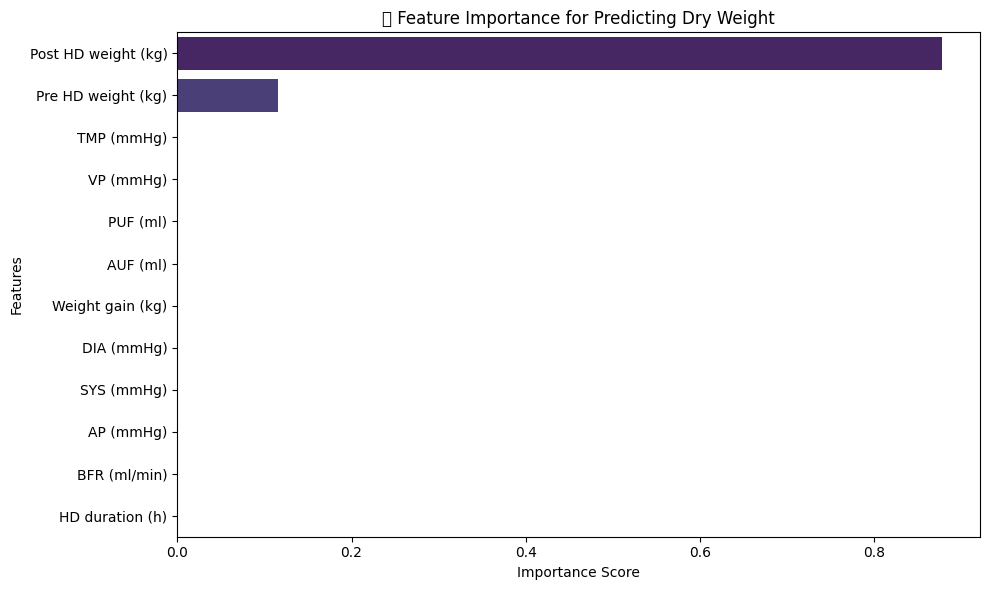

In [26]:
# Get feature importances
importances = model.feature_importances_
features = X.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title("🔍 Feature Importance for Predicting Dry Weight")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()